# Workshop #7. Single-cell embeddings

In [ ]:
!pip install scanpy[leiden] scrublet openTSNE snapatac2
!gdown "1Ctq4EmV2ps1dMiFcbqW467ywezRSGGN0&confirm=t"
!unzip PBMC_10k.zip

In [2]:
import scanpy as sc
import snapatac2 as snap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sc.set_figure_params(dpi=150)
sns.set_style("ticks")

In [3]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    inplace=True,
    log1p=False,
    percent_top=None,
)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


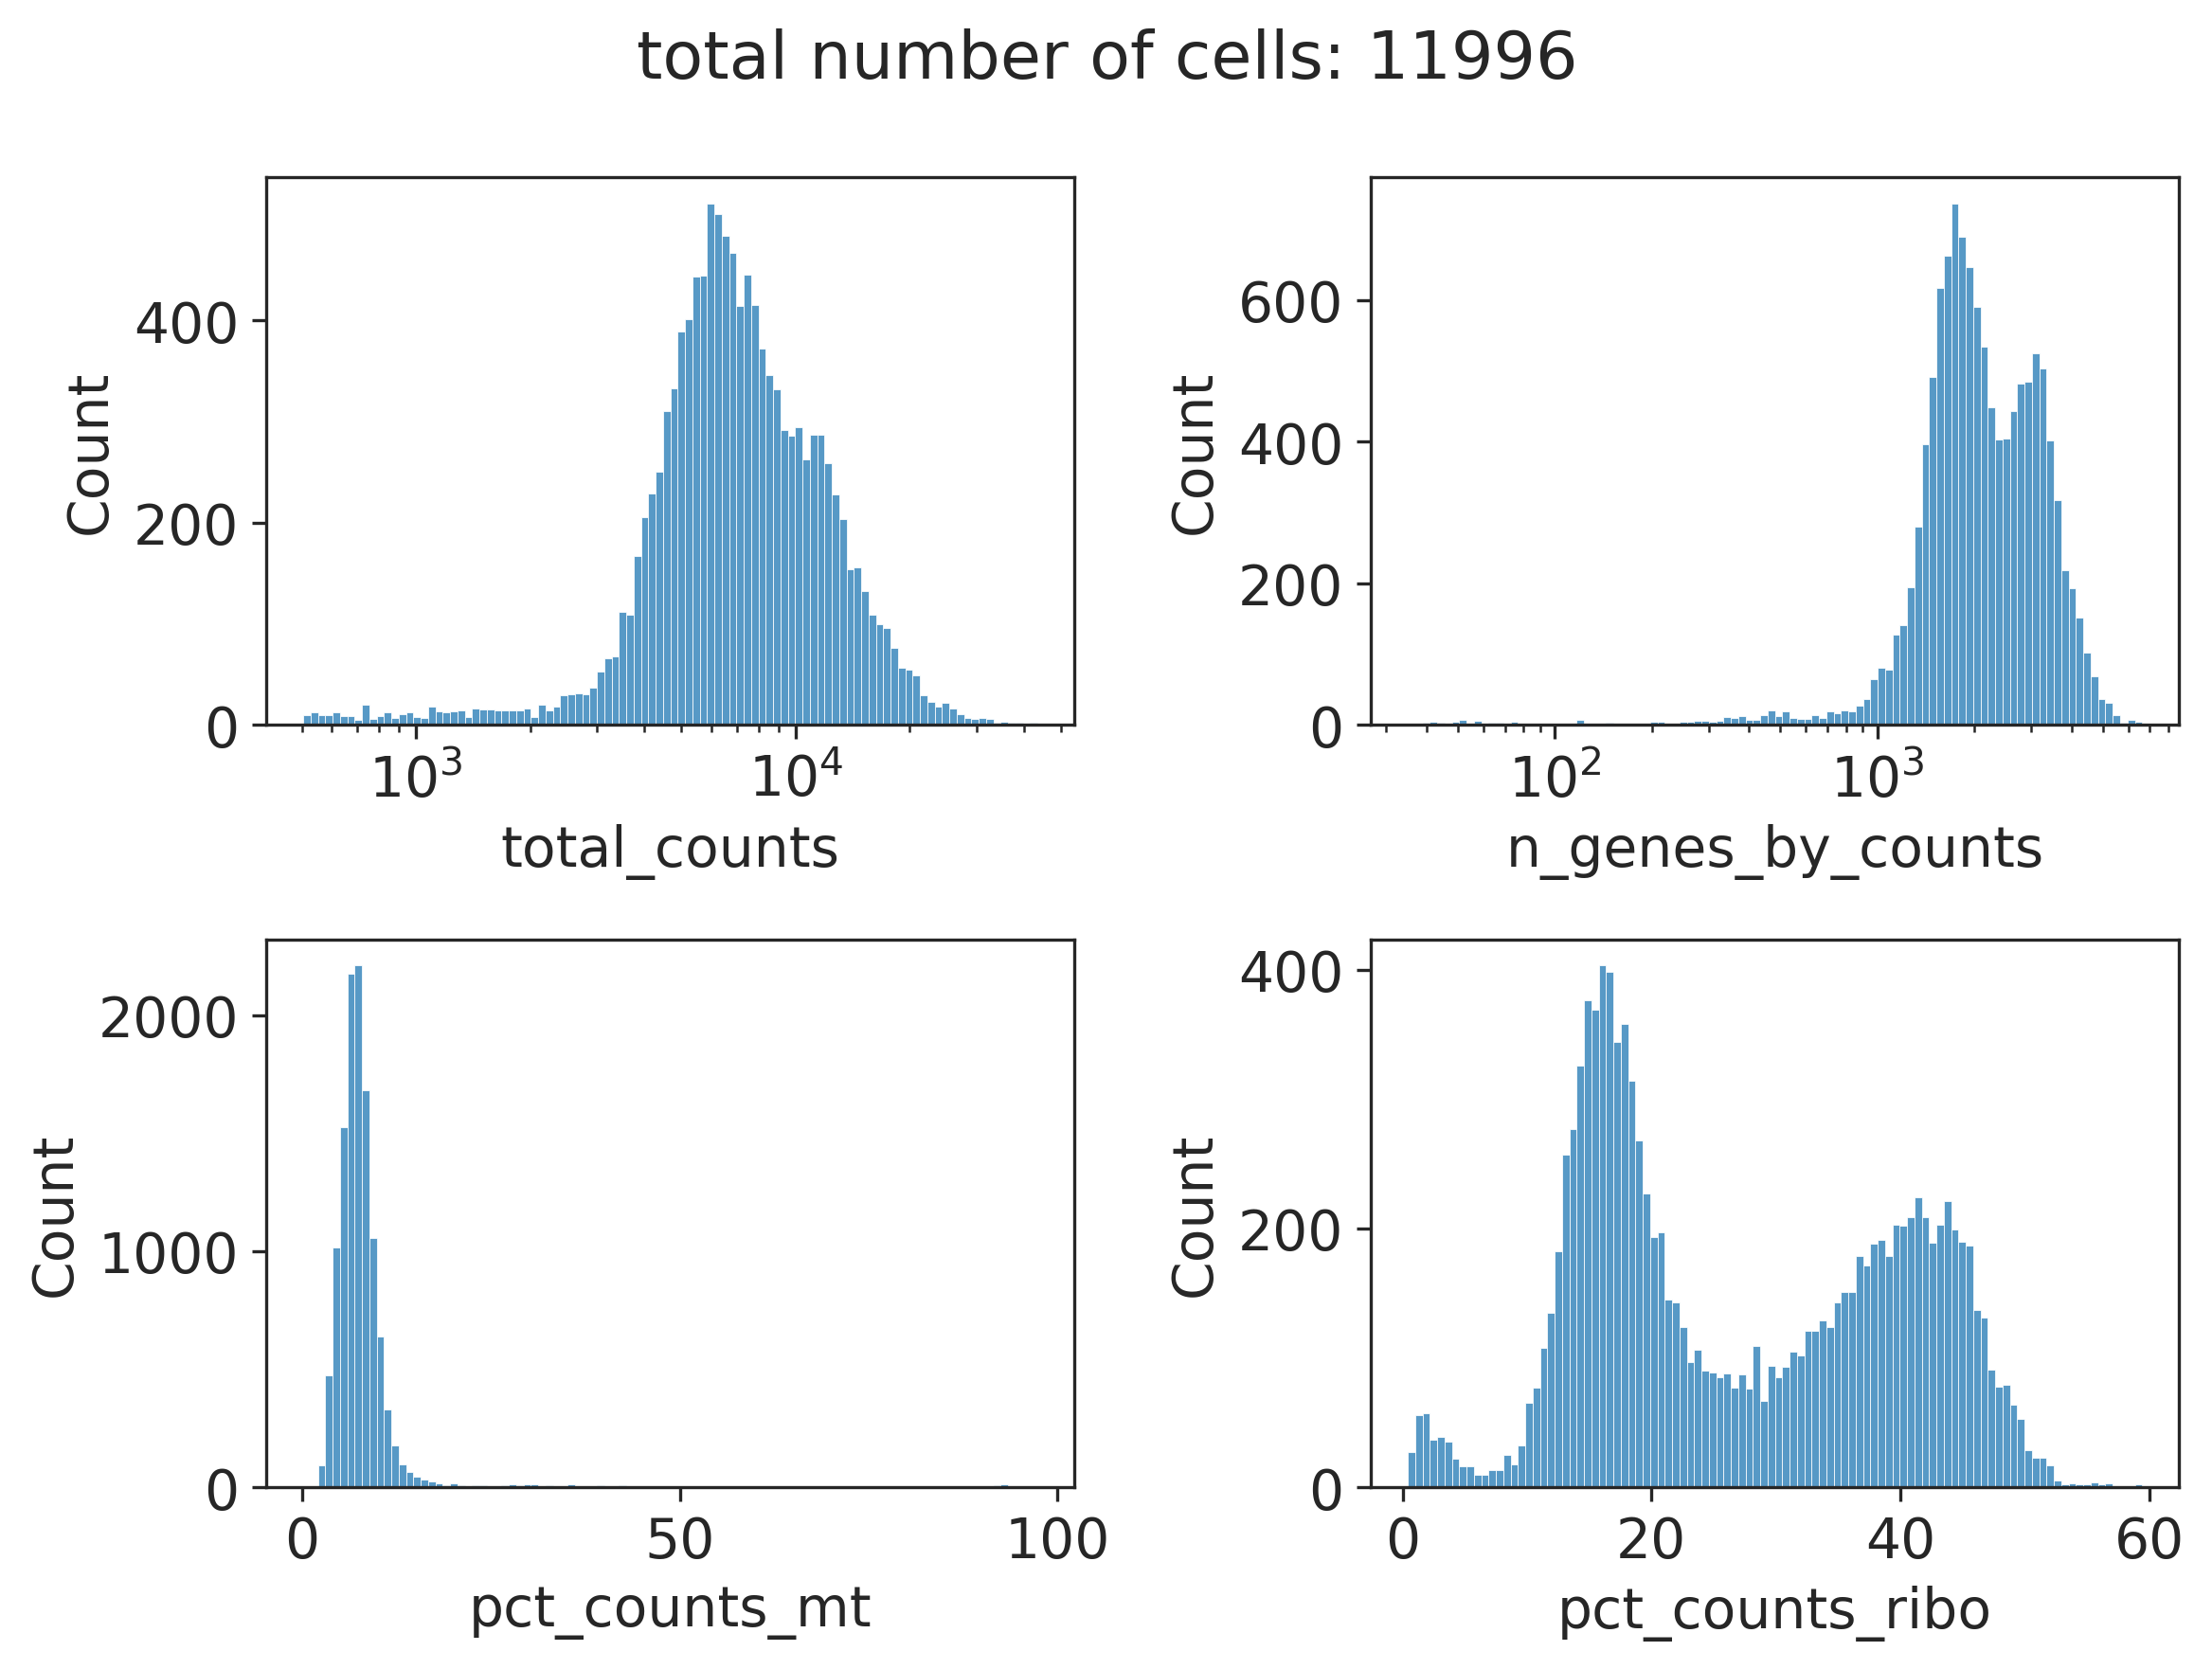

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

sns.histplot(adata.obs.total_counts, ax=axes[0, 0], log_scale=True, bins=100)
sns.histplot(adata.obs.n_genes_by_counts, ax=axes[0, 1], log_scale=True, bins=100)
sns.histplot(adata.obs.pct_counts_mt, ax=axes[1, 0], bins=100)
sns.histplot(adata.obs.pct_counts_ribo, ax=axes[1, 1], bins=100)

plt.suptitle(f"total number of cells: {len(adata)}")

fig.tight_layout()

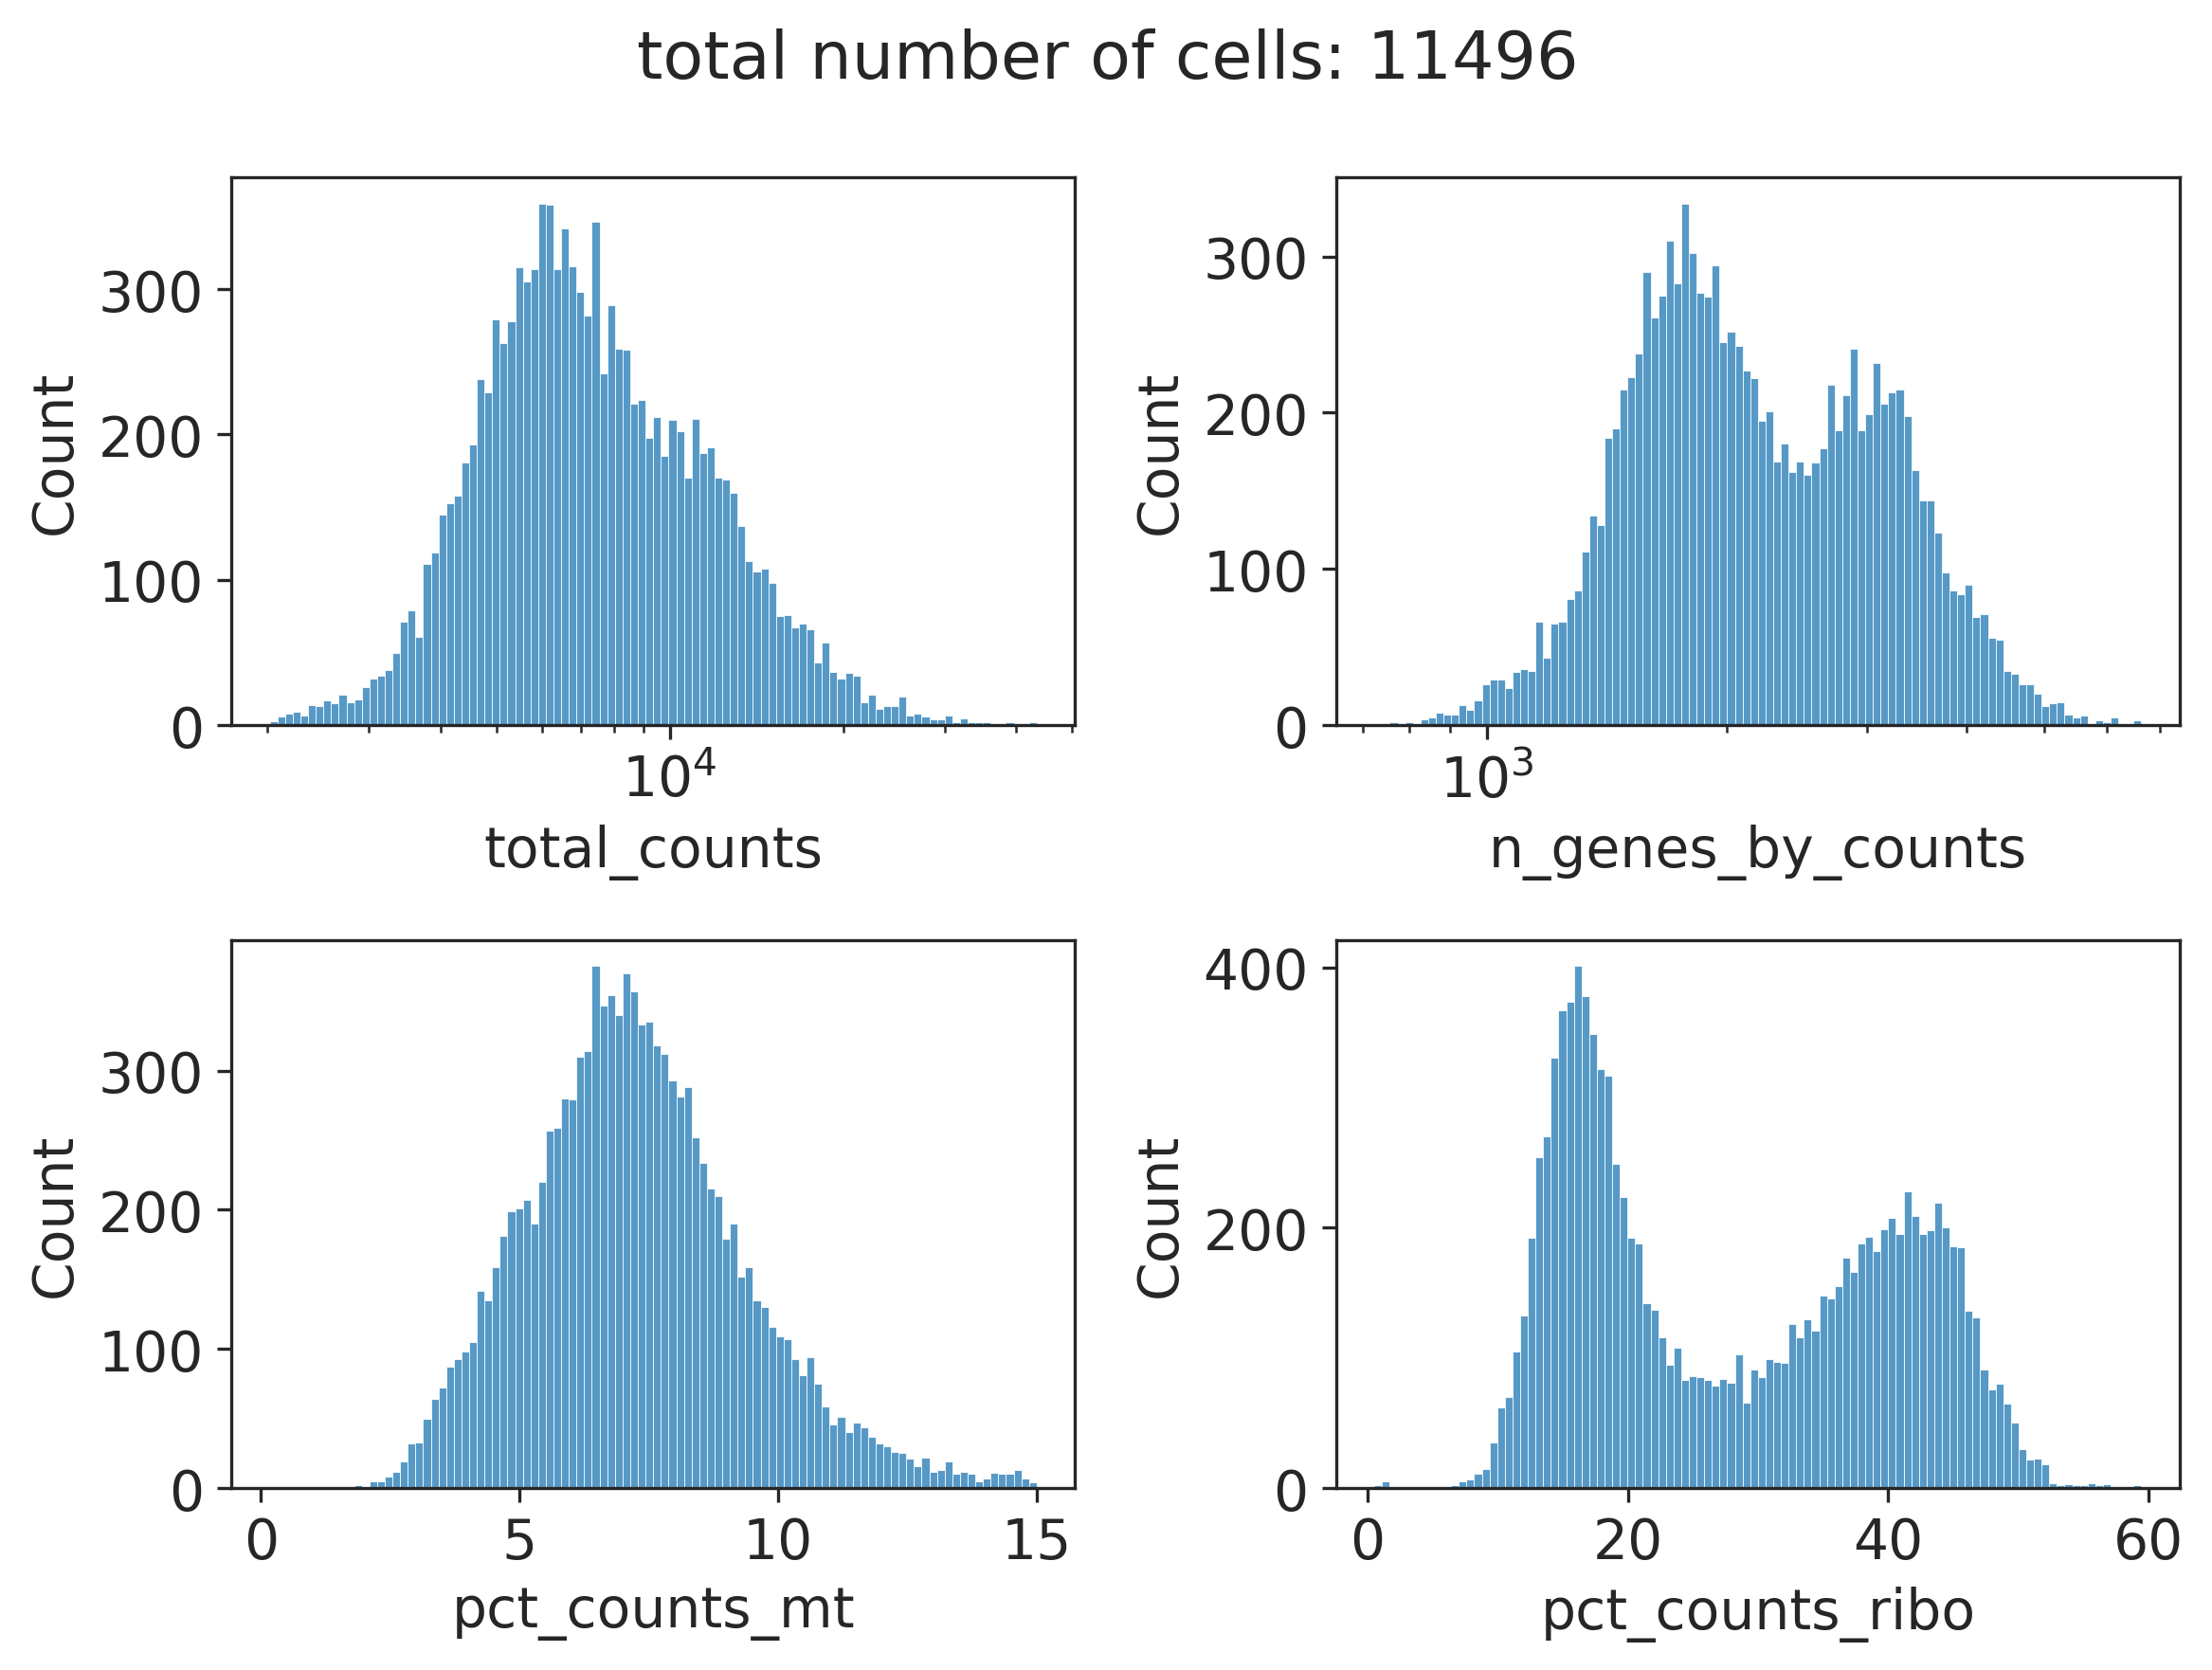

In [5]:
# Step 1: QC

adata = adata[adata.obs.pct_counts_mt < 15]
adata = adata[adata.obs.total_counts > 2000]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

sns.histplot(adata.obs.total_counts, ax=axes[0, 0], log_scale=True, bins=100)
sns.histplot(adata.obs.n_genes_by_counts, ax=axes[0, 1], log_scale=True, bins=100)
sns.histplot(adata.obs.pct_counts_mt, ax=axes[1, 0], bins=100)
sns.histplot(adata.obs.pct_counts_ribo, ax=axes[1, 1], bins=100)

plt.suptitle(f"total number of cells: {len(adata)}")

fig.tight_layout()

In [6]:
# Step 2: doublets filtration

sc.pp.scrublet(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scrublet/__init__.py:286: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


In [7]:
# Step 3: variance stabilization

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [8]:
# Step 5: HVG selection

sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata.raw = adata

adata = adata[:, adata.var.highly_variable]

In [9]:
# Step 6: scaling

sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


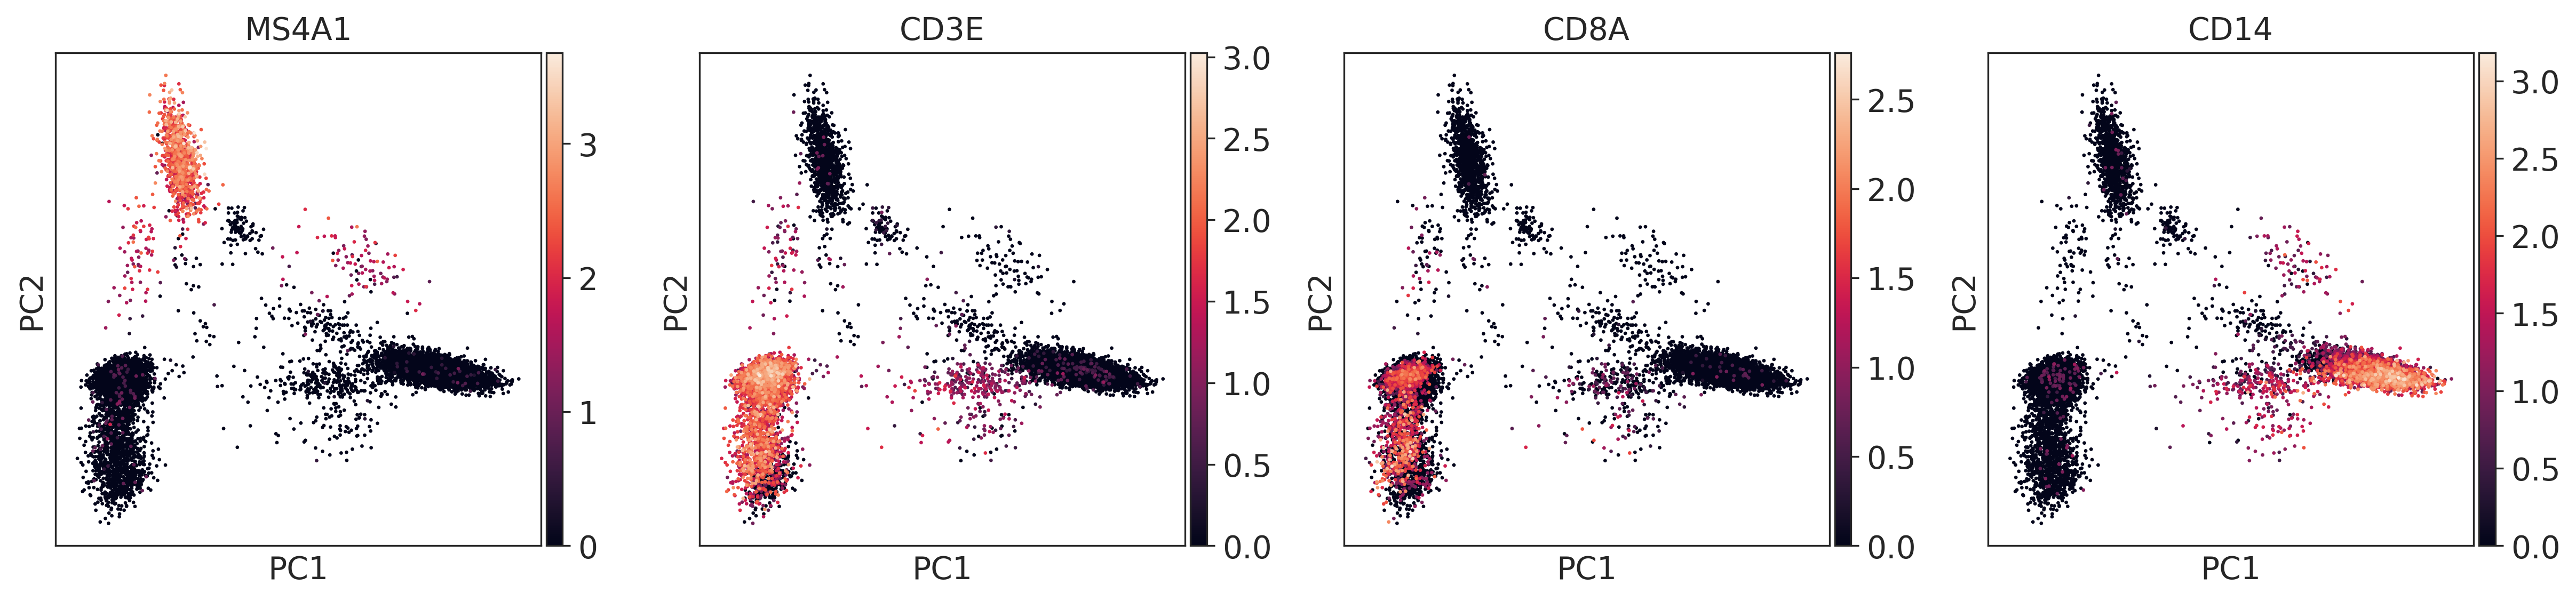

In [10]:
# Step 7: PCA

sc.pp.pca(adata)
sc.pl.pca(adata, color=["MS4A1", "CD3E", "CD8A", "CD14"])

In [11]:
# Step 8: kNN construction
sc.pp.neighbors(adata, use_rep="X_pca", n_pcs=20)

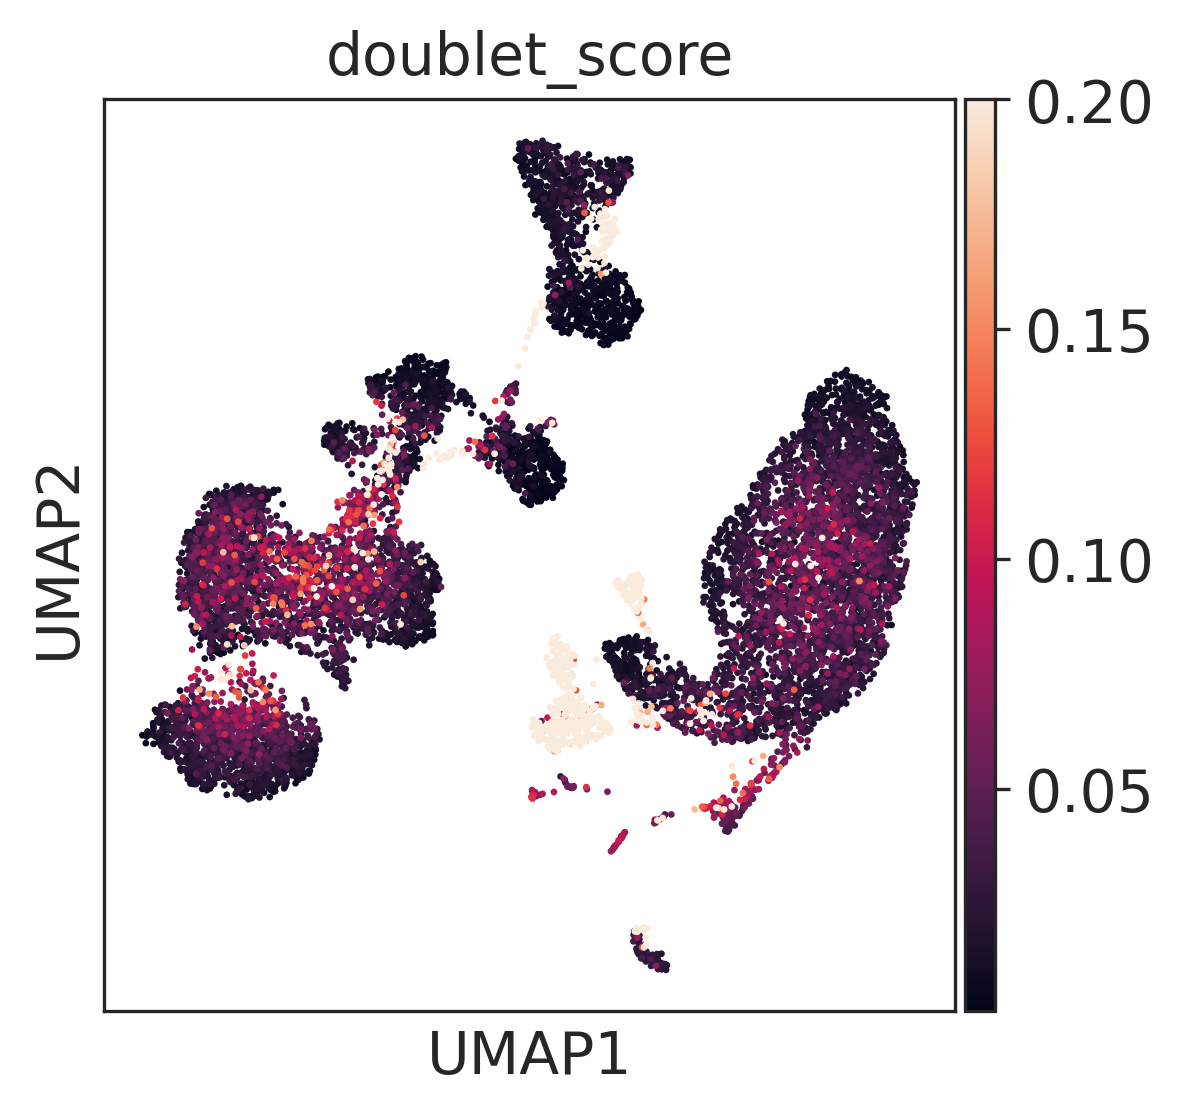

In [12]:
# Step 9: UMAP

sc.tl.umap(adata)
sc.pl.umap(adata, color=["doublet_score"], vmax=0.2)

/usr/local/lib/python3.10/dist-packages/snapatac2/tools/_embedding.py:292: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['spectral_eigenvalue'] = evals


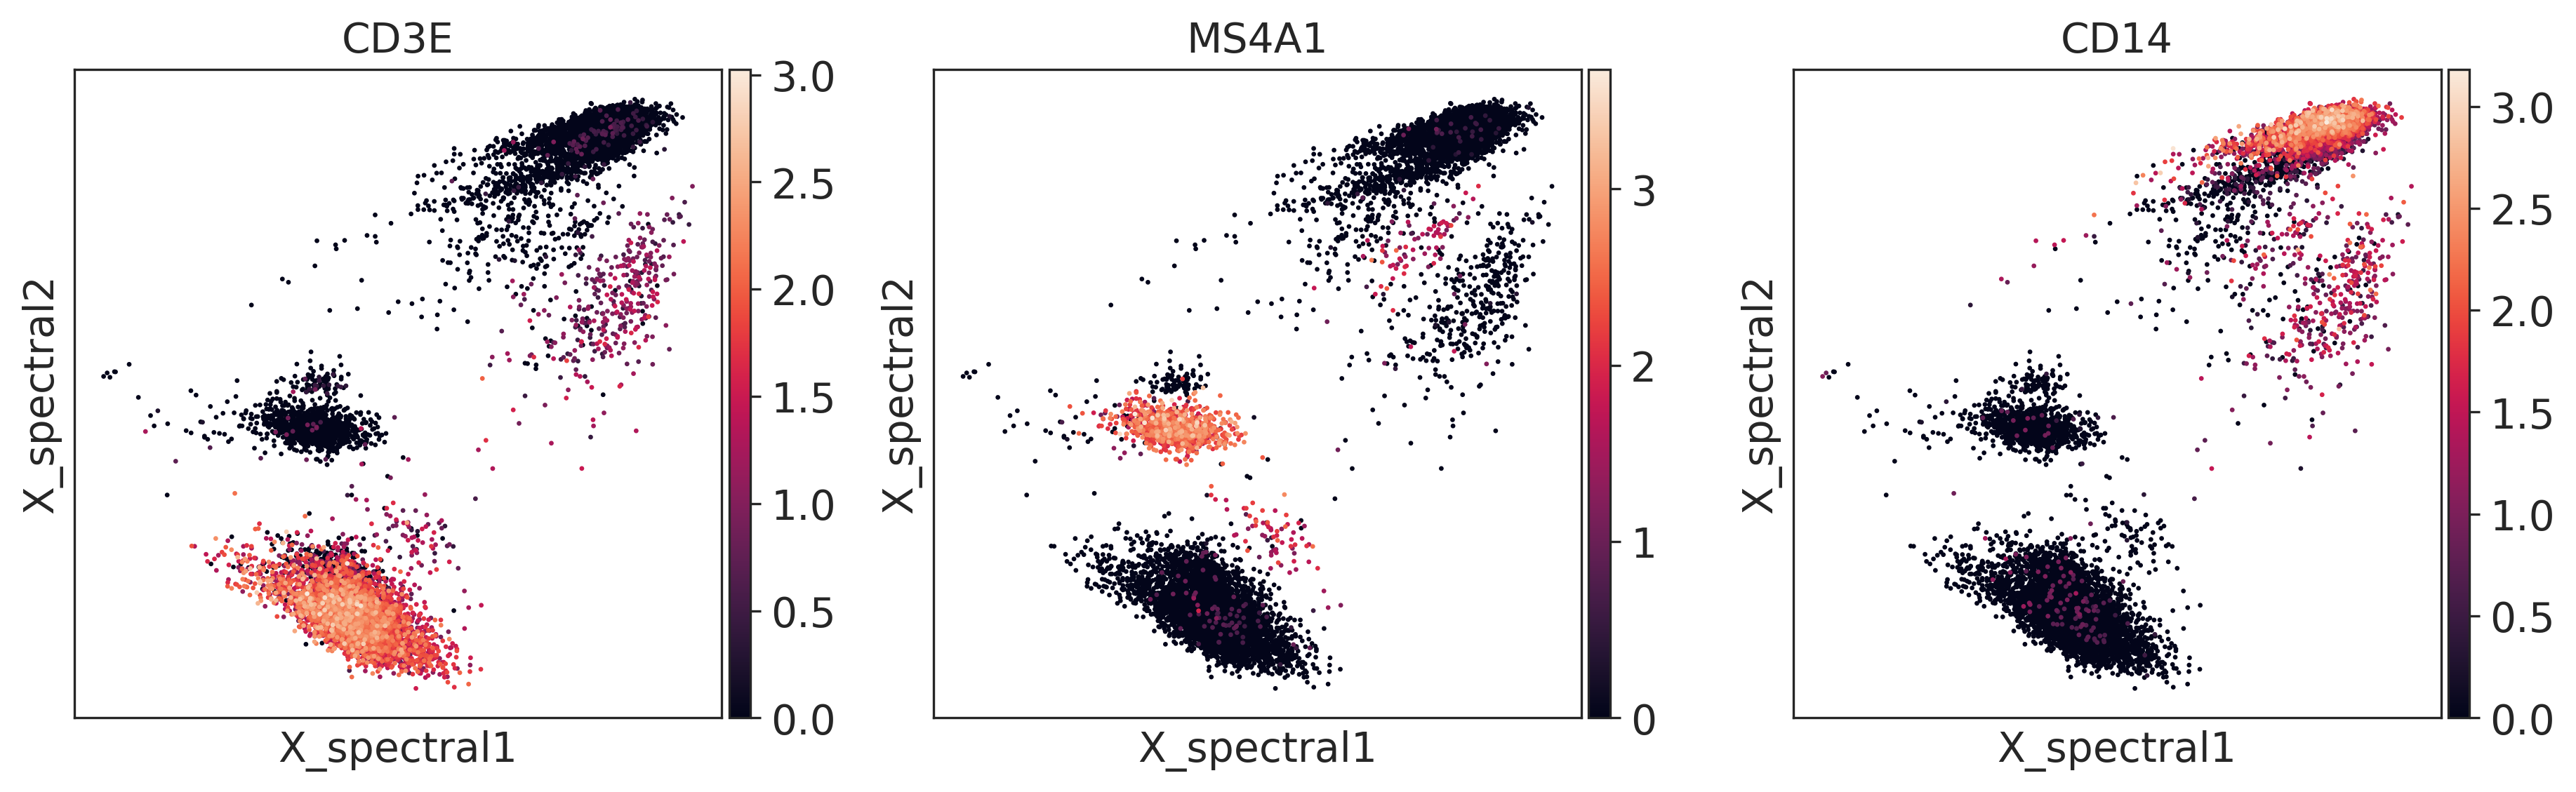

In [13]:
# Alternative step 7: spectral embedding
adata = adata.raw.to_adata()
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

snap.tl.spectral(adata, features=None)
sc.pl.embedding(adata, basis="X_spectral", color=["CD3E", "MS4A1", "CD14"])

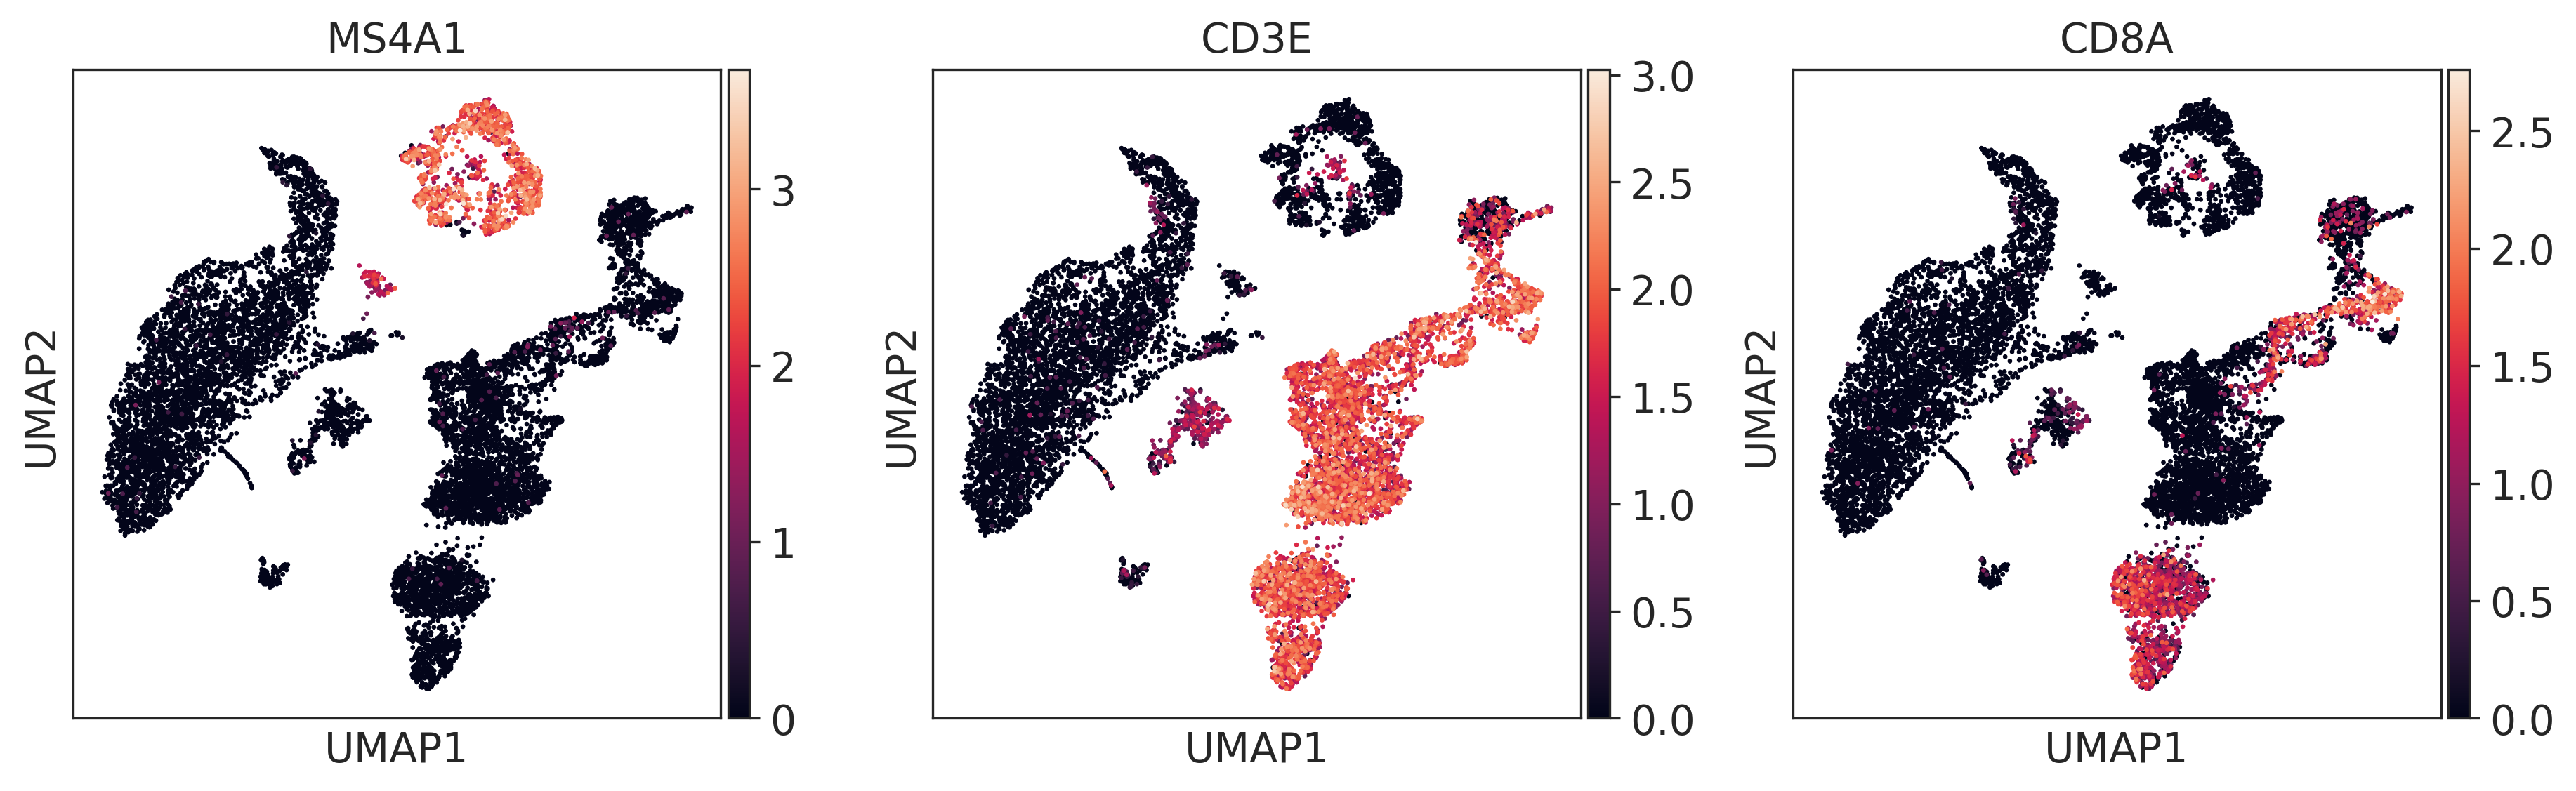

In [14]:
# Last steps: kNN on spectral coordinates and UMAP

sc.pp.neighbors(adata, use_rep="X_spectral", n_pcs=20)

sc.tl.umap(adata)
sc.pl.umap(adata, color=["MS4A1", "CD3E", "CD8A"])

# Hometask

## Task 1

Please, code (without using ready-to-go single-cell tools) one of the following dimensionality reduction and describe similarities / dissimilarities with PCA in resulting embedding. Feel free in methods and interpretation — creativity is a key:

1. LDA,
2. VAE,
3. ICA.

In [48]:
X = adata.X.A

In [52]:
from sklearn.decomposition import FastICA

ICA = FastICA(n_components=2)

In [53]:
X_ica = ICA.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [54]:
adata.obsm['X_ica'] = X_ica

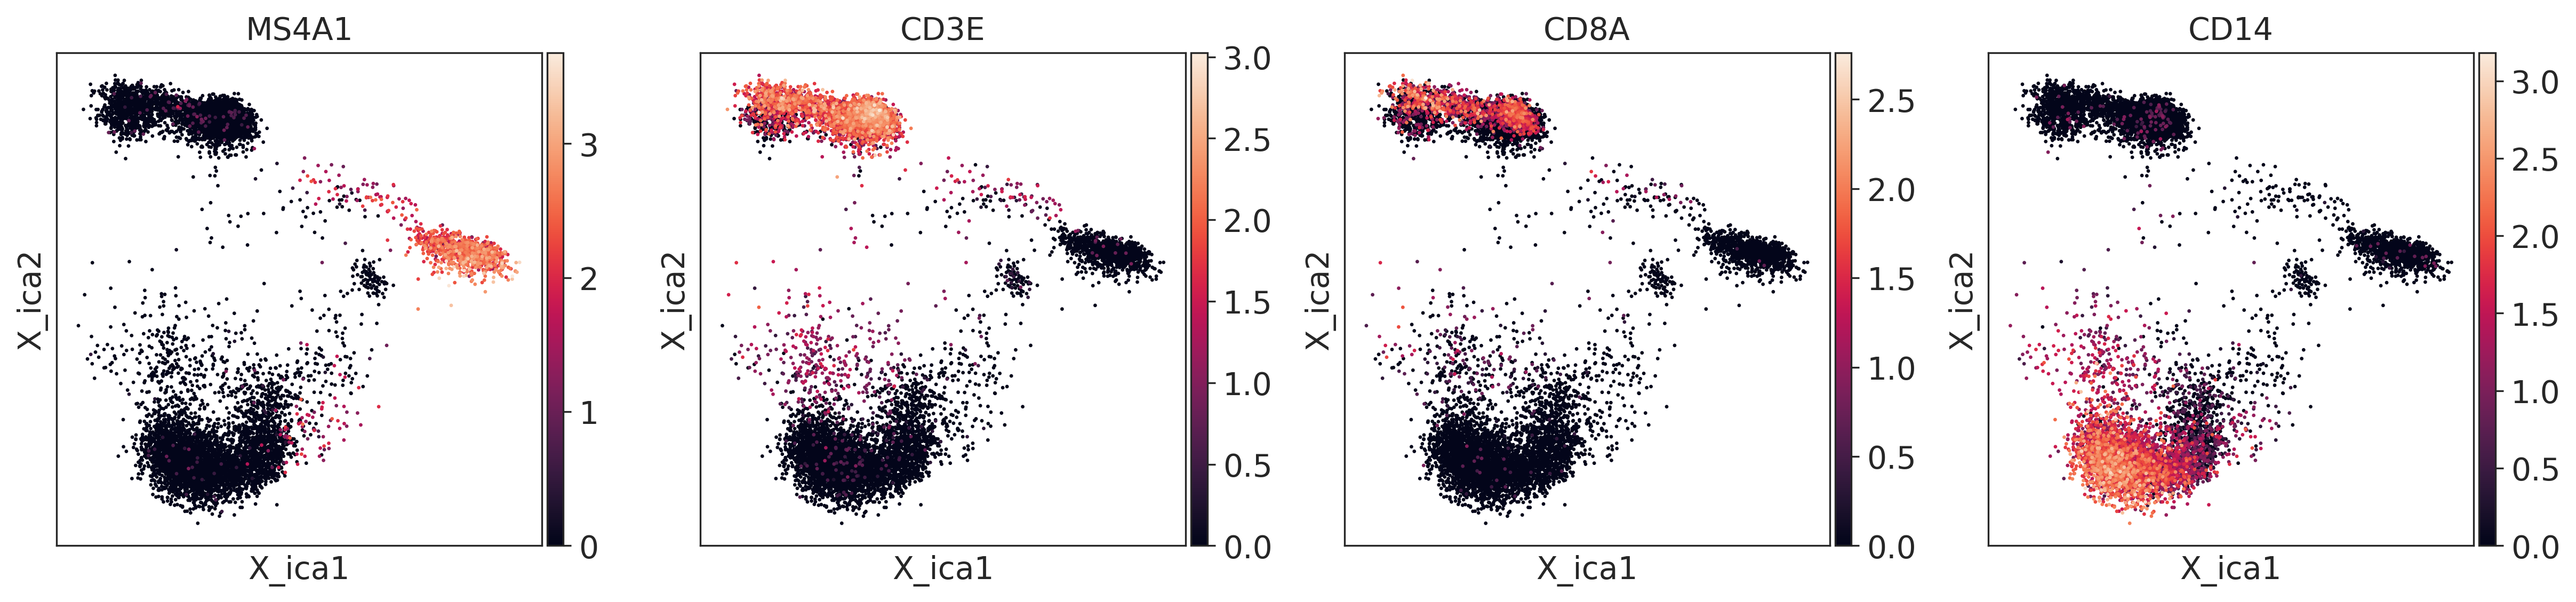

In [55]:
sc.pl.embedding(adata, basis="X_ica", color=["MS4A1", "CD3E", "CD8A", "CD14"])

In general, the embeddings for PCA and ICA are similar and show approximately the same results
